# Time-Series Analysis using PyCaret: Dhaka Tribune

## Highlights

* PyCaret Time-Series Problem

### Dataset: Dhaka Tribune 2021 Dataset. 

* Training Period: 2021-04-23 to 2021-06-18 
* Test/Validation Period: 2021-06-19 to 2021-06-26

Author: Sumaia Parveen Shupti

Created on: 07/07/2021

Updated on: 07/10/2021

## Import Libraries

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

## Install PyCaret

In [21]:
#!pip install pycaret-ts-alpha

## Load & Clean Dhaka Tribune 2021 Dataset

In [22]:
df1 = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df1['Accident date'] = pd.to_datetime(df1['Accident date'])
df1 = df1[['Accident date', 'Deaths']]
df1.columns = ['Period', 'Deaths']
df1 = df1.sort_values(by = 'Period')
df1 = df1.reset_index(drop = True).set_index('Period').resample('1D').sum().reset_index()
df_2021 = df1[1652:]
df_2021

,Period,Deaths
1652,2021-01-01,11.0
1653,2021-01-02,0.0
1654,2021-01-03,7.0
1655,2021-01-04,0.0
1656,2021-01-05,0.0
...,...,...
1824,2021-06-22,0.0
1825,2021-06-23,3.0
1826,2021-06-24,0.0
1827,2021-06-25,0.0


## Feature Engineering

In [23]:
df_2021['Date'] = df_2021['Period'].dt.date
df_2021['Year'] = df_2021['Period'].dt.year
df_2021['Month'] = df_2021['Period'].dt.month
df_2021['Day'] = df_2021['Period'].dt.day
df_2021['Day_name'] = df_2021['Period'].dt.day_name()
df_2021['DayofWeek'] = df_2021['Period'].dt.weekday
df_2021['Weekend_(y/n)'] = ((df_2021['Period'].dt.dayofweek) // 5 == 1).astype(float)
df_2021['DayofYear'] = df_2021['Period'].dt.dayofyear
# Convert the date into a number (of days since some point)
fromDate = min(df_2021['Period'])
df_2021['DateInt'] = (df_2021['Period'] - fromDate).astype(np.int64)/100000000000
df_2021.head()

,Period,Deaths,Date,Year,Month,Day,Day_name,DayofWeek,Weekend_(y/n),DayofYear,DateInt
1652,2021-01-01,11.0,2021-01-01,2021,1,1,Friday,4,0.0,1,0.0
1653,2021-01-02,0.0,2021-01-02,2021,1,2,Saturday,5,1.0,2,864.0
1654,2021-01-03,7.0,2021-01-03,2021,1,3,Sunday,6,1.0,3,1728.0
1655,2021-01-04,0.0,2021-01-04,2021,1,4,Monday,0,0.0,4,2592.0
1656,2021-01-05,0.0,2021-01-05,2021,1,5,Tuesday,1,0.0,5,3456.0


Taking the below columns for the Regression and Time-Series Problem.

In [24]:
df_2021 = df_2021[[ 'Date', 'Year', 'Month', 'Day', 'DayofWeek', 'Weekend_(y/n)', 'DayofYear', 'DateInt', 'Deaths']]
df_2021.head()

,Date,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,Deaths
1652,2021-01-01,2021,1,1,4,0.0,1,0.0,11.0
1653,2021-01-02,2021,1,2,5,1.0,2,864.0,0.0
1654,2021-01-03,2021,1,3,6,1.0,3,1728.0,7.0
1655,2021-01-04,2021,1,4,0,0.0,4,2592.0,0.0
1656,2021-01-05,2021,1,5,1,0.0,5,3456.0,0.0


## Train Test Split

* Test/Validation data = 7 days data
* Training data =  8 weeks data

In [25]:
start_ = df_2021.Date.max()
end_ = df_2021.Date.min()

test_end = df_2021.Date.max()
test_start = df_2021.Date.max() - timedelta(days = 7)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 56)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-26
Dataset End Date: 2021-01-01
 
Train Set Start Date: 2021-04-23
Train Set End Date: 2021-06-18
 
Test Set Start Date: 2021-06-19
Test Set End Date: 2021-06-26
 


In [26]:
mask = (df_2021.Date >= train_start) & (df_2021.Date <= train_end)
train = df_2021.loc[mask]
train = train.drop('Date', 1)

mask = (df_2021.Date >= test_start) & (df_2021.Date <= test_end)
test = df_2021.loc[mask]
test = test.drop('Date', 1)

In [27]:
train.tail()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,Deaths
1816,2021,6,14,0,0.0,165,141696.0,0.0
1817,2021,6,15,1,0.0,166,142560.0,0.0
1818,2021,6,16,2,0.0,167,143424.0,6.0
1819,2021,6,17,3,0.0,168,144288.0,0.0
1820,2021,6,18,4,0.0,169,145152.0,3.0


In [28]:
test.head()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,Deaths
1821,2021,6,19,5,1.0,170,146016.0,7.0
1822,2021,6,20,6,1.0,171,146880.0,0.0
1823,2021,6,21,0,0.0,172,147744.0,0.0
1824,2021,6,22,1,0.0,173,148608.0,0.0
1825,2021,6,23,2,0.0,174,149472.0,3.0


## PyCaret Time Series Analysis

### Import libraries

In [29]:
from pprint import pprint
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

from sktime.utils.plotting import plot_series

### Loading Dataset

In [30]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df = df_2021.set_index('Date')
y = df.Deaths
y

Date
2021-01-01    11.0
2021-01-02     0.0
2021-01-03     7.0
2021-01-04     0.0
2021-01-05     0.0
              ... 
2021-06-22     0.0
2021-06-23     3.0
2021-06-24     0.0
2021-06-25     0.0
2021-06-26     2.0
Name: Deaths, Length: 177, dtype: float64

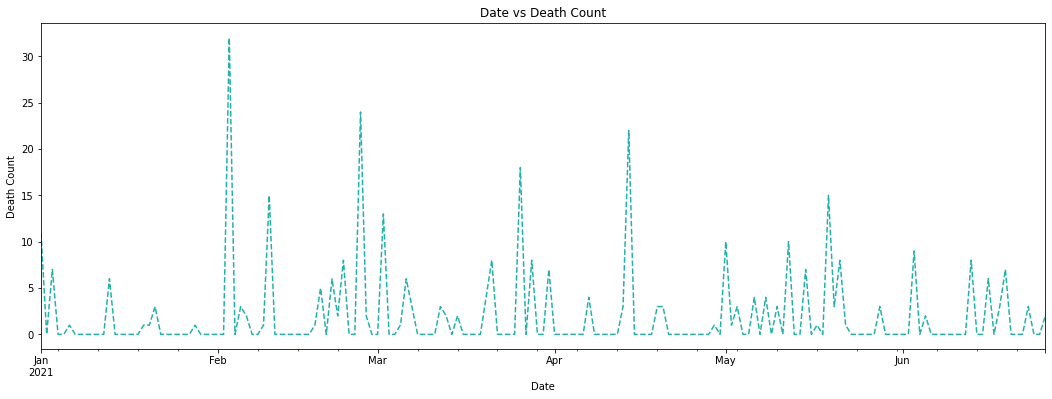

In [31]:
plt.figure(figsize=(18, 6))
y.plot(color = 'lightseagreen', linestyle = '--')
plt.title('Date vs Death Count')
plt.ylabel('Death Count')
plt.show()

### Setup PyCaret Time Series Experiment

In [32]:
exp = TimeSeriesExperiment()
exp.setup(data=y, fh=7, fold=3, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(177, 1)"
2,Missing Values,False
3,Transformed Train Set,"(170,)"
4,Transformed Test Set,"(7,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,CPU Jobs,-1
8,Use GPU,False
9,Log Experiment,False


### List of Available Models

In [33]:
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
ets,ETS,sktime.forecasting.ets.AutoETS,True
theta,Theta Forecaster,sktime.forecasting.theta.ThetaForecaster,True
tbats,TBATS,sktime.forecasting.tbats.TBATS,False


### Compare Different Models

In [34]:
%%time
best_baseline_models = exp.compare_models(n_select=3, sort='mape')

,Model,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.8648,11.3008,1060828799413555.3750,1.9559,-0.4126,0.0367
naive,Naive Forecaster,2.3333,12.9048,3002399751580330.5000,2.0000,-0.4474,1.0200
snaive,Seasonal Naive Forecaster,2.3333,16.0476,3002399751580330.5000,2.0000,-0.4917,0.0100
arima,ARIMA,2.4070,16.3336,3191259646623606.5000,2.0000,-0.5240,0.0900
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.4500,13.5936,5226535965558162.0000,1.9087,-0.1720,0.0367
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,2.7972,12.8870,5978257062649131.0000,1.8863,-0.3521,1.2233
auto_arima,Auto ARIMA,2.5178,9.4250,6023700267709583.0000,1.6994,-0.0988,1.0867
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,2.5644,9.7550,6072874461313715.0000,1.7157,-0.1336,0.0333
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.8544,13.4950,6159993609667484.0000,1.8978,-0.3697,0.0500
ets,ETS,2.4739,11.6191,6345189502980764.0000,1.6628,-0.2669,0.0667


CPU times: user 14.6 s, sys: 472 ms, total: 15 s
Wall time: 1min 31s


## Reference

* https://nbviewer.jupyter.org/github/pycaret/sktime-dev-days-2021/blob/main/sktime_dev_days_101.ipynb